In [6]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model (ResNet50)
model = models.resnet50(pretrained=True)
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "D:\Project\Python\DeepLearning\CNN\images\puppy.jpg"  # Replace with your image path
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension


In [7]:

# Target layer (last convolutional layer of ResNet)
target_layer = model.layer4[2].conv3  

# Store gradients and activations
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])  # Save first-order gradient

def forward_hook(module, input, output):
    activations.append(output)  # Save feature maps

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [8]:
# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)  # Get predicted class

# Compute gradients for the target class
model.zero_grad()
output[0, pred_class].backward(retain_graph=True)

# Extract gradients and activations
grads = gradients[0].detach()  # (batch_size, channels, H, W)
acts = activations[0].detach()  # (batch_size, channels, H, W)


d:\Project\Python\DeepLearning\.venv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [9]:
# Compute second-order and third-order gradients
grads2 = grads ** 2  # Second-order gradient
grads3 = grads ** 3  # Third-order gradient

# Compute alpha weights
alpha_numerator = grads2
alpha_denominator = 2 * grads2 + torch.sum(acts * grads3, dim=[2, 3], keepdim=True)
alpha_denominator = torch.where(alpha_denominator != 0, alpha_denominator, torch.ones_like(alpha_denominator))  # Avoid division by zero
alpha = alpha_numerator / alpha_denominator

# Compute importance weights
weights = torch.sum(alpha * torch.relu(grads), dim=[2, 3], keepdim=True)  # Weighted sum of gradients


In [10]:
# Compute Grad-CAM++ heatmap
cam = torch.sum(weights * acts, dim=1).squeeze(0)  # Weighted sum over channels

# Apply ReLU to retain only positive contributions
cam = F.relu(cam)

# Normalize heatmap
cam -= cam.min()
cam /= cam.max()


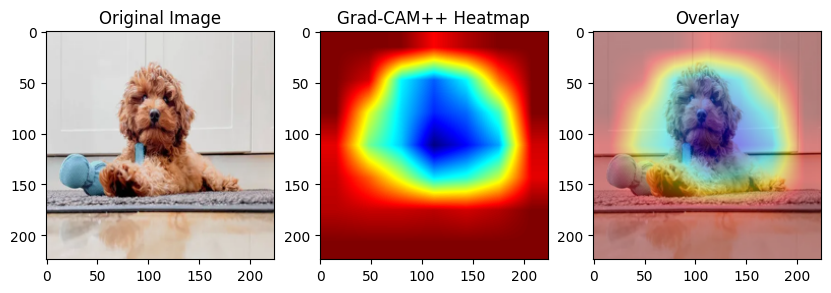

In [11]:
# Resize heatmap to match image size
heatmap = cv2.resize(cam.numpy(), (224, 224))

# Convert to colormap
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Convert original image to NumPy
original = np.array(image.resize((224, 224)))

# Superimpose heatmap on original image
superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM++ Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.title("Overlay")
plt.show()
